# Installation and import section

In [1]:
#!pip3 install clean-text
#!pip3 install contractions
#!pip3 install html5lib
#!pip3 install lxml
#!pip3 install matplotlib
#!pip3 install pandas
#!pip3 install requests
#!pip3 install scikit-learn

In [2]:
import contractions
import html
import nltk
import os
import re
import requests
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from cleantext import clean
from nltk.stem.snowball import EnglishStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, Perceptron
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
#nltk.download('stopwords')
#nltk.download('punkt')

Every package used for this task can be used for commercial purposes

# Function definition section

In [5]:
def clean_text_general(text):
    """ 
    This function has as input a string and outputs a string. 
    The objective is to normalize emails and numbers with the same token.   
    """
    
    cleaned_text = clean(text,
                         no_emails=True,  # replace all email addresses with a special token
                         no_numbers=True,  # replace all numbers with a special token
                         replace_with_email="email",
                         replace_with_number="number",
                         lang="en")
    return cleaned_text


def clean_text_url(text):
    """ 
    This function has as input a string and outputs a string. 
    The objective is to normalize urls with the same token. 
    """
    
    cleaned_text = clean(text,
                         no_urls=True,  # replace all URLs with a special token
                         lang="en")
    return cleaned_text


def emoticon_detection(text, emoticons):
    """ 
    This function has as inputs a string and list of strings and outputs a string. 
    The objective is to detect emoticons and normalize them with the same token. 
    """
    
    for emoticon in emoticons:
        new_text_lst = []
        lst_text = text.split(emoticon)
        if len(lst_text) > 1:
            text = f' {emoticon} '.join(lst_text)
            tokens = text.split()
            for token in tokens:
                if token == emoticon:
                    new_text_lst.append('emoticon')
                else:
                    new_text_lst.append(token)
            text = ' '.join(new_text_lst)
    return text


def number_split(text):
    """ 
    This function has as input a string and outputs a string. 
    The objective is to detect numbers and split them even if they are concatenated with other strings. 
    """
    return ' '.join(re.split('(\d+)', text)).strip()


def stopwords_detection(text, stop):
    """ 
    This function has as inputs a string and a list of strings and outputs a string. 
    The objective is to detect stopwords and remove them. 
    """
    return ' '.join([token for token in word_tokenize(text) if not token in stop])


def stemming(text, stemmer):
    """ 
    This function has as inputs a string and a stemmer and outputs a string. 
    The objective is to stem the input string. 
    """
    return ' '.join([stemmer.stem(token) for token in word_tokenize(text)])


def preprocess(text, emoticons, stop, stemmer):
    """ 
    This function has as inputs a string, a list of emoticons, a list of stopwords, and a stemmer 
    and outputs a string. 
    The objective is to process all textual data to enhance its quality.
    """
    text = text.lower()
    text = html.unescape(text)
    text = text.replace("\ufeff", "")
    text = re.sub("(<a.+>)", "URL", text)
    text = re.sub("<.+>", "", text)
    text = re.sub(r"\S*\.com\S*|\S*watch\?\S*|\S*\. com\S*", 'URL', text)
    text = contractions.fix(text)
    text = clean_text_url(text)
    text = emoticon_detection(text, emoticons)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = number_split(text)
    text = clean_text_general(text)
    text = stopwords_detection(text, stop)
    text = stemming(text, stemmer)
    return text


def visualize_word_freq_top_n(input_data, title_pre, n=20):
    """ 
    This function has as inputs a collection of comments, a string title, and a int to describe the top and outputs
    the plot and shape of the vocabulary.
    """
    
    vectorizer = CountVectorizer(lowercase=False)
    TITLE = f"{title_pre} - Top {n} Words"
        
    mat = vectorizer.fit_transform(input_data)
    
    pd.DataFrame(mat.sum(axis=0).T,
             index=vectorizer.get_feature_names(),
             columns=['freq']).sort_values(by='freq',
                                           ascending=False)[0:n].plot(kind='barh',title=TITLE)
    return mat.shape


def unique_tokens(input_data):
    """ 
    This function has as input a collection of comments and outputs the df with unique words.
    """
    vectorizer = CountVectorizer(lowercase=False)
        
    mat = vectorizer.fit_transform(input_data)
    
    df = pd.DataFrame(mat.sum(axis=0).T,
             index=vectorizer.get_feature_names(),
             columns=['freq'])
    df = df[df.freq == 1]
    return df


def to_labels(pos_probs, threshold):
    """ 
    This function has as inputs a list of floats and a float and outputs a list of ints.
    The objective is to change classification decisions based on threshold values.
    """
    return (pos_probs >= threshold).astype('int')

# Exploratory Data Analysis - First Iteration
## General Overview

In [6]:
# Load dataset
data = pd.read_csv(f'Data/SpamDataset.csv', encoding='latin-1')
data.head(20)

,Unnamed: 0,Unnamed: 1,COMMENT_ID,AUTHOR,DATE,COMMENT,LABEL
0,Psy,0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,Psy,1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,Psy,2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,Psy,3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ?,1
4,Psy,4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .?,1
5,Psy,5,LZQPQhLyRh9-wNRtlZDM90f1k0BrdVdJyN_YsaSwfxc,Jason Haddad,2013-11-26T02:55:11,"Hey, check out my new website!! This site is a...",1
6,Psy,6,z13lfzdo5vmdi1cm123te5uz2mqig1brz04,ferleck ferles,2013-11-27T21:39:24,Subscribe to my channel ?,1
7,Psy,7,z122wfnzgt30fhubn04cdn3xfx2mxzngsl40k,Bob Kanowski,2013-11-28T12:33:27,i turned it on mute as soon is i came on i jus...,0
8,Psy,8,z13ttt1jcraqexk2o234ghbgzxymz1zzi04,Cony,2013-11-28T16:01:47,You should check my channel for Funny VIDEOS!!?,1
9,Psy,9,z12avveb4xqiirsix04chxviiljryduwxg0,BeBe Burkey,2013-11-28T16:30:13,and u should.d check my channel and tell me wh...,1


- Inspecting only the first $20$ elements of the dataframe one concludes that there is a usage of emoticons, URLs, mixed cases, usage of contractions and slang words, and acronyms. 
- This was expected due to the nature of the data as well the common use of e-mails and digits in some phising comments.

In [7]:
print(data.shape)
print(data.dtypes)

(1956, 7)
Unnamed: 0    object
Unnamed: 1     int64
COMMENT_ID    object
AUTHOR        object
DATE          object
COMMENT       object
LABEL          int64
dtype: object


- The provided dataset is comprised of $1,956$ entries with $7$ columns;
- The majority of these columns contain textual information;
- Unnamed: 0 seems to be a previous index column containing information about the artist;
- Unnamed: 1 also seems to be a previous index column containing information about the number of comments associated to the artist. This columns is not relevant for the classification task;
- COMMENT_ID, AUTHOR, and DATE do not have any relevant information for the classification task;
- COMMENT is the main source of information for the classification and some details were already described above;
- LABEL consists on the binarized 'SPAM'/'HAM' outcome. Here SPAM is $1$ and HAM is $0$.

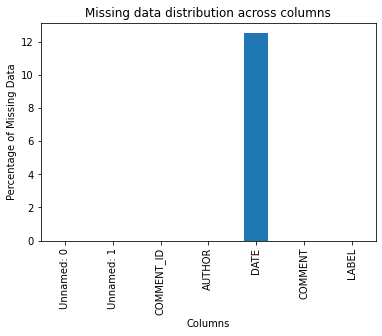

In [8]:
(data.isnull().sum() * 100 / len(data)).plot.bar()  # Percentage Missing Data
plt.ylabel('Percentage of Missing Data')
plt.xlabel('Columns')
plt.title('Missing data distribution across columns')
plt.show()

From the previous plot one notes that only the DATE column has missing data, more precisely, it has $12.5\%$ of missing data. 

This is not to worry since this column is not relevant for the classification task.

Just to be sure that our comment column always has any information lets strip the strings and compute the length of the comments.

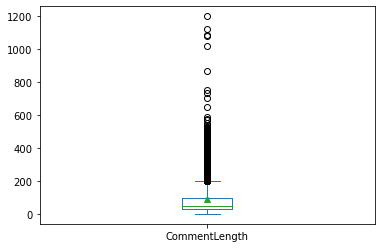

count    1956.000000
mean       94.672802
std       128.193389
min         2.000000
25%        29.000000
50%        48.000000
75%        97.000000
max      1200.000000
Name: CommentLength, dtype: float64

In [9]:
data['CommentLength'] = data.COMMENT.apply(lambda x: len(x.strip()))
data['CommentLength'].plot.box(showmeans=True)
plt.show()
data['CommentLength'].describe()

Now we are sure that all comment entries have some information given the minimum length being $2$.

From the boxplot we can interpret the following:
- Comments length distribution is positively skewed;
- Half the comments have a length greater than or equal to $48$ and half have less;
- $25\%$ of comments have a length greater than $97$;
- The interquartile range tells us that the middle $50\%$ of comment length in the dataset have a spread of $97-29=68$;
- The upper whisker represent the upper $25\%$ of comment length, i.e., $12.5\%$ of comments have a length greater than $97+1.5*68=199$.

In [10]:
# Dropping irrelavant columns
data = data.drop(columns=['Unnamed: 1', 'COMMENT_ID', 'AUTHOR', 'DATE', 'CommentLength'])
data = data.rename(columns={'Unnamed: 0': 'Artist'}) # This may be relevant for model analysis

## Target Overview

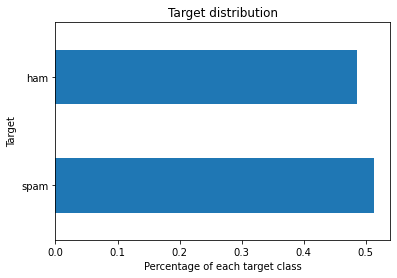

In [11]:
data.LABEL.\
    replace({0: 'ham',
             1: 'spam'}).value_counts(normalize=True).plot(kind='barh')  # Target Distribution
plt.ylabel('Target')
plt.xlabel('Percentage of each target class')
plt.title('Target distribution')
plt.show()

Apparently this is a balanced binary classification problem given that target classes are almost equaly distributed! 

What if we partition by artist?

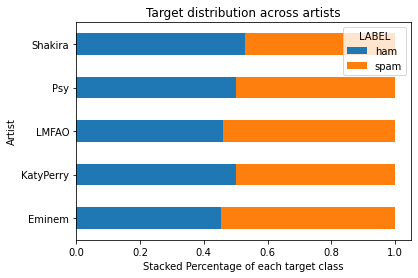

In [12]:
data.groupby('Artist').LABEL\
    .value_counts(normalize=True).unstack().rename(columns={0: 'ham', 1: 'spam'}).plot.barh(stacked=True)  
plt.ylabel('Artist')
plt.xlabel('Stacked Percentage of each target class')
plt.title('Target distribution across artists')
plt.show()

The only artists with more spam comments than the others are LMFAO and Eminem. 

Honestly I was expecting for Psy to be the artist with more spam comments given its popularity back in the day!

Neverthless, after visualizing the target distribution after partitioning by artist we can still see that it is balanced.

# Web Scrapping

- Given that emoticons are present in the data and they are a different representation of punctuation given emotional association to them, special care was given to this detail. 
- Web scrapping was done to extract a list of emoticons from Wikipedia and it was further processed due to the low quality of the automatic extraction.
- The following code should be partitioned into functions. This was not done to show every step of the web scrapping and emoticon corpus processing strategies.

In [13]:
page = requests.get("https://en.wikipedia.org/wiki/List_of_emoticons") # get URL

wikitables = pd.read_html(page.text.replace('<br />',' ')) # List of dataframes with all wikitables in the page
df = pd.concat(wikitables)
df

,0,1,2,3,4,5,6,7,8,9,...,Icon.1,Icon.2,Icon.3,Icon.4,Icon.5,Icon.6,Icon.7,Icon.8,Icon.9,Meaning
0,NaN,This article contains special characters. With...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,:-] :],:-> :>,8-) 8),:-} :},:o),:c),:^),=],=),Smiley or happy face.[4][5][6][7]
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8‑D 8D,=D,=3,B^D,c:,C:,C:,C:,C:,"Laughing,[4] big grin,[5][6] grinning with gla..."
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X‑D XD,X‑D XD,X‑D XD,X‑D XD,X‑D XD,X‑D XD,X‑D XD,X‑D XD,X‑D XD,Laughing[9][10][11]
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,:-)),:-)),:-)),:-)),:-)),:-)),:-)),:-)),:-)),Very happy or double chin[8]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,NaN,0,1,2,3,4,5,6,7,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,U+1F91x,🤐,🤑,🤒,🤓,🤔,🤕,🤖,🤗,🤘,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,U+1F92x,🤠,🤡,🤢,🤣,🤤,🤥,🤦,🤧,🤨,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,U+1F93x,🤰,🤱,🤲,🤳,🤴,🤵,🤶,🤷,🤸,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- This extraction is... Quite something! We need to reset the index given some repetition across the different concatenated dataframes.
- Also, the only relevant columns are the icon ones, even if they have missing values but this will be taken into account shortly.

In [14]:
df = df.reset_index()
df.columns = [str(col) for col in df.columns]
df = df[df.columns[[x.startswith("Icon") for x in df.columns]]] # Consider only the relevant columns
df

,Icon,Icon.1,Icon.2,Icon.3,Icon.4,Icon.5,Icon.6,Icon.7,Icon.8,Icon.9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,:‑) :),:-] :],:-> :>,8-) 8),:-} :},:o),:c),:^),=],=)
2,:‑D :D,8‑D 8D,=D,=3,B^D,c:,C:,C:,C:,C:
3,x‑D xD,X‑D XD,X‑D XD,X‑D XD,X‑D XD,X‑D XD,X‑D XD,X‑D XD,X‑D XD,X‑D XD
4,:-)),:-)),:-)),:-)),:-)),:-)),:-)),:-)),:-)),:-))
...,...,...,...,...,...,...,...,...,...,...
234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
emoticon = df.to_numpy() # Instead of using df.values for performance purposes
emoticon = emoticon[~pd.isna(emoticon)] # Lets get rid of the missing data in our array!
emoticon

array([':‑) :)', ':-] :]', ':-> :>', '8-) 8)', ':-} :}', ':o)', ':c)',
       ':^)', '=]', '=)', ':‑D :D', '8‑D 8D', '=D', '=3', 'B^D', 'c:',
       'C:', 'C:', 'C:', 'C:', 'x‑D xD', 'X‑D XD', 'X‑D XD', 'X‑D XD',
       'X‑D XD', 'X‑D XD', 'X‑D XD', 'X‑D XD', 'X‑D XD', 'X‑D XD', ':-))',
       ':-))', ':-))', ':-))', ':-))', ':-))', ':-))', ':-))', ':-))',
       ':-))', ':‑( :(', ':‑c :c', ':‑< :<', ':‑[ :[', ':-||', '>:[',
       ':{', ':@', ':(', ';(', ":'‑( :'(", ':=(', ':=(', ':=(', ':=(',
       ':=(', ':=(', ':=(', ':=(', ':=(', ":'‑) :')", ':"D', ':"D', ':"D',
       ':"D', ':"D', ':"D', ':"D', ':"D', ':"D', "D‑':", 'D:<', 'D:',
       'D8', 'D;', 'D=', 'DX', 'DX', 'DX', 'DX', ':‑O :O', ':‑o :o',
       ':-0', '8‑0', '>:O', '=O =o =0', '=O =o =0', '=O =o =0',
       '=O =o =0', '=O =o =0', ':-3 :3', '=3', 'x3 X3', 'x3 X3', 'x3 X3',
       'x3 X3', 'x3 X3', 'x3 X3', 'x3 X3', 'x3 X3', '>:3', '>:3', '>:3',
       '>:3', '>:3', '>:3', '>:3', '>:3', '>:3', '>:3', ':-* :*', ':×',
   

Now this looks much better! The next step is to normalize everything by lowercasing the emoticons and get rid of the one character and longer emoticons to avoid wrong detections and speed up the process.

Note that it will be added $3$ emoticons given their absence in the corpus.

In [16]:
emoticon_unique = []

for emo in emoticon:
    emos = emo.split()
    for e in emos:
        if len(e) > 1 and len(e) < 4:
            emoticon_unique.append(e.lower())
            
print(len(emoticon_unique))
print(len(set(emoticon_unique)))

emoticon_unique.append('^_^')
emoticon_unique.append('^-^')
emoticon_unique.append('^^')

emoticon_unique = list(set(emoticon_unique)) # Remove duplicates from the list
emoticon_unique

461
188


['＿＿',
 '＼/',
 '∧∧',
 ':e',
 '><>',
 'x_x',
 '(>ミ',
 '8-)',
 '<3',
 'o:)',
 '=)',
 ':}',
 ':^)',
 ';3',
 '>.>',
 ':|',
 '＼|',
 ':‑)',
 ':‑p',
 ':‑&',
 'x-3',
 'qq',
 '(╬',
 '中＼',
 '8‑d',
 ':s',
 'd:',
 ';^)',
 'm(_',
 '(づ￣',
 '*)',
 '>;)',
 '=\\',
 '</3',
 '8=x',
 '|‑o',
 '~:>',
 '∧＿∧',
 '^-^',
 'sto',
 ':]',
 ':‑j',
 '͡°)',
 ':‑b',
 ':$',
 ':o',
 '༎ຶ',
 ':d',
 ':×',
 ':‑#',
 ')>',
 '8d',
 ':‑<',
 '｀）',
 ':<',
 '●～*',
 'otl',
 '>:[',
 'ಠ_ಠ',
 '┏━┓',
 '◥▅◤',
 ':)',
 ':‑[',
 'd=',
 'x‑p',
 '>:\\',
 '=3',
 '%‑)',
 ';(',
 'o-o',
 ')ᕗ',
 '台＼',
 '8‑0',
 '>:/',
 '*-)',
 'xp',
 ';‑]',
 '>:3',
 'b-)',
 '+_+',
 ':(',
 '>:o',
 '_)>',
 'b^d',
 '͡°',
 ';]',
 '<\\3',
 '}:)',
 'x3',
 ':‑.',
 'd8',
 'xd',
 '>:)',
 '(v)',
 ':/',
 ';)',
 ':[',
 ':‑d',
 '⁄)',
 ':=(',
 ':l',
 ':&',
 'c:',
 ':‑þ',
 '8=d',
 ':"d',
 'otz',
 '^_^',
 ':þ',
 ':-0',
 'ಠ益ಠ',
 ':-*',
 '=]',
 ':3',
 '\\o/',
 'd:<',
 '=o',
 '0:3',
 '͜ʖ',
 '0:)',
 '(⁄',
 'v.v',
 'd;',
 '≡≡彡',
 ':-]',
 ')(',
 '^m^',
 ':-}',
 ':-3',
 '◢▅◣',
 'ºノ)',
 '>

Our emoticon corpus consists of $188$ unique elements. Feel free to check them out!

# Exploratory Data Analysis - Textual Data


Now we can process our data resorting to the main processing function. Every detail is present in the function definition section.

In [17]:
stopwords = nltk.corpus.stopwords.words("english")
snowstemmer = EnglishStemmer()
data['Clean'] = data.COMMENT.apply(lambda x: preprocess(x, emoticon_unique, stopwords, snowstemmer))
data.head(20)

,Artist,COMMENT,LABEL,Clean
0,Psy,"Huh, anyway check out this you[tube] channel: ...",1,huh anyway check youtub channel kobyoshi number
1,Psy,Hey guys check out my new channel and our firs...,1,hey guy check new channel first vid us monkey ...
2,Psy,just for test I have to say murdev.com,1,test say url
3,Psy,me shaking my sexy ass on my channel enjoy ^_^ ?,1,shake sexi ass channel enjoy emoticon
4,Psy,watch?v=vtaRGgvGtWQ Check this out .?,1,url check
5,Psy,"Hey, check out my new website!! This site is a...",1,hey check new websit site kid stuff kidsmediau...
6,Psy,Subscribe to my channel ?,1,subscrib channel
7,Psy,i turned it on mute as soon is i came on i jus...,0,turn mute soon came want check view emoticon
8,Psy,You should check my channel for Funny VIDEOS!!?,1,check channel funni video
9,Psy,and u should.d check my channel and tell me wh...,1,shouldd check channel tell next


We can see an huge quality improvement by removing unecessary noise in the data and normalize it.

Now it is time to compare word distributions between raw and processed data.

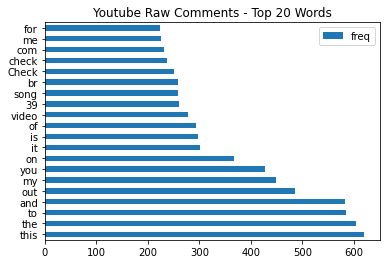

In [18]:
raw_shape = visualize_word_freq_top_n(data.COMMENT, 'Youtube Raw Comments')

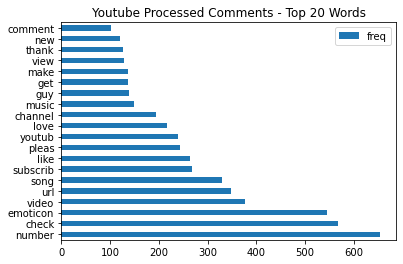

In [19]:
processed_shape = visualize_word_freq_top_n(data.Clean, 'Youtube Processed Comments')

In [20]:
print(f'Vocabulary size for raw comments is made out of {raw_shape[1]} tokens')
print(f'Vocabulary size for processed comments is made out of {processed_shape[1]} tokens')

Vocabulary size for raw comments is made out of 5457 tokens
Vocabulary size for processed comments is made out of 2904 tokens


So, we can see that the processing pipeline reduced the vocabulary size by $46.8\%$ which is great to reduce data sparsity!

We can also see that the top $20$ tokens for the raw data are mainly composed of stopwords and URLs references. For the processed data, we get more meaningful tokens.

Since we are doing some vizualizations, what if we do the same but now partitioning by the target variable?

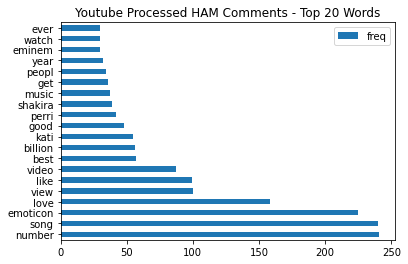

In [21]:
processed_ham_shape = visualize_word_freq_top_n(data[data.LABEL == 0].Clean, 'Youtube Processed HAM Comments')

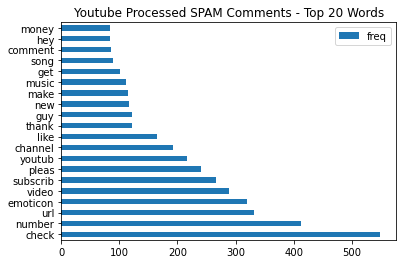

In [22]:
processed_spam_shape = visualize_word_freq_top_n(data[data.LABEL == 1].Clean, 'Youtube Processed SPAM Comments')

In [23]:
print(f'Vocabulary size for processed spam comments is made out of {processed_spam_shape[1]} tokens')
print(f'Vocabulary size for processed ham comments is made out of {processed_ham_shape[1]} tokens')

Vocabulary size for processed spam comments is made out of 2272 tokens
Vocabulary size for processed ham comments is made out of 1215 tokens


One notes that the vocabulary size of spam comments is greater than the one for the ham scenario, it is $187.0\%$ bigger.

For the ham distribution, comments mention the artists, number of views, appreciation, and nostalgia.

For the spam distribution, comments mention channels, have subscription requests, use a lot of URLs, and mention money.

The emoticon and number tokens appear in the top in both distributions which indicates that it probably will not be helpful to distinguish between classes.

To finish the EDA, lets take a look into unique words in the vocabulary

In [24]:
unique_processed = unique_tokens(data.Clean)
print(unique_processed.head(20))
print(unique_processed.shape)

             freq
aaaaaaa         1
abba            1
ablaz           1
absorb          1
abusedmistr     1
abusu           1
acaer           1
accept          1
accessori       1
accident        1
accomplish      1
acid            1
across          1
actress         1
adapt           1
addfollow       1
addict          1
addit           1
adhoc           1
adi             1
(1725, 1)


In [25]:
unique_raw = unique_tokens(data.COMMENT)
print(unique_raw.head(20))
print(unique_raw.shape)

                                                    freq
002                                                    1
018                                                    1
02                                                     1
034                                                    1
04                                                     1
047000                                                 1
05                                                     1
053012                                                 1
0687119038                                             1
0CB8QFjAA                                              1
0LaviqU2b                                              1
0d878a889c                                             1
0dbHjZdW0LbsJBi40gXm0D0p5KRhv8XInQlI53__wQBaHS8...     1
10000000                                               1
1000000000                                             1
100000415527985                                        1
100005244783212                

In [26]:
print(f'Percentage of unique words in processed vocabulary = \
{round(unique_processed.shape[0]*100/processed_shape[1], 1)}')

print(f'Percentage of unique words in raw vocabulary = {round(unique_raw.shape[0]*100/raw_shape[1], 1)}')

Percentage of unique words in processed vocabulary = 59.4
Percentage of unique words in raw vocabulary = 61.4


Despite the decrease of the percentage of unique words after processing there exists still several unique tokens. 

This is an indicator that not all textual features will be relevant for the classification task.

# Machine Learning

As any machine learning project, one needs to separate the data into at least two sets, one for training and one for testing.

Given the reduced amount of data, it was decided to split only into two sets and perform cross-validation during training to use the data as much as possible.

Despite the dataset being balanced, stratification was still done using the target variable and the artist to guarantee that target distribution is the same between sets and to try to avoid several out-of-vocabulary tokens given the percentage of unique words.

In [27]:
le = LabelEncoder()
data['ArtistCat'] = le.fit_transform(data['Artist']) # Encode Artist column for stratification purposes
df_train, df_test = train_test_split(data, stratify=data[['LABEL', 'ArtistCat']], test_size=0.2, random_state=42)

Now that we have our sets, we will perform model benchmarking composed by the most suitable linear models for the classification task to decide which will be optimized. 

Even though that the dataset is balanced and stratification was done, the scoring metric will be one independent of the decision threshold. 

For this purpose the average-precision was selected as a way to represent a proxy of the area under the precision-recall curve.

Regarding feature extraction, as a baseline approach the bag of words approach was selected.

In [28]:
cv = CountVectorizer()
features_train = cv.fit_transform(df_train.Clean)
features_test = cv.transform(df_test.Clean)

In [29]:
models = [LogisticRegression(random_state=42), MultinomialNB(), ComplementNB(), 
          LinearSVC(random_state=42), PassiveAggressiveClassifier(random_state=42), 
          Perceptron(random_state=42)]

for model in models:
    scores = cross_val_score(model, features_train, df_train['LABEL'], cv=5, scoring='average_precision')
    model_name = str(model).split('(')[0]
    print(f'Results for {model_name}:')
    print(f'Mean AP: {round(scores.mean(), 3)}. Range: [{round(scores.mean() - scores.std(), 3)}; {round(scores.mean() + scores.std(), 3)}]\n')

Results for LogisticRegression:
Mean AP: 0.985. Range: [0.982; 0.988]

Results for MultinomialNB:
Mean AP: 0.972. Range: [0.965; 0.978]

Results for ComplementNB:
Mean AP: 0.972. Range: [0.965; 0.978]

Results for LinearSVC:
Mean AP: 0.982. Range: [0.978; 0.986]

Results for PassiveAggressiveClassifier:
Mean AP: 0.976. Range: [0.973; 0.98]

Results for Perceptron:
Mean AP: 0.97. Range: [0.965; 0.975]



Given the benchmark the two best performing models were the Logistic Regression and the SVM with linear kernel. 

Comparing the standard deviated range of both we see that the dispersion value is very similar between predictions.

Given this, both models will be considered for the optimization stage.

In [30]:
# Initialize pipeline
pipe = Pipeline([
                    ('vect', CountVectorizer()),
                    ('clf', LogisticRegression(random_state=42))
                ])

In [31]:
# Target hyper-parameters for both algorithms and feature extraction
parameters = [
    {
        'clf': [LogisticRegression(random_state=42)],
        'clf__C': [0.01, 0.1, 1.0],
        'clf__class_weight': [None, 'balanced'],
        'clf__solver': ['newton-cg', 'lbfgs'],
        'vect__min_df': [1, 2, 10, 50],
        'vect__max_df': [0.5, 0.7, 0.8, 1.0]
    }, 
    
    {
        'clf': [LinearSVC(random_state=42)],
        'clf__C': [0.1, 1.0],
        'clf__class_weight': [None, 'balanced'],
        'clf__loss': ['hinge', 'squared_hinge'],
        'vect__min_df': [1, 2, 10, 50],
        'vect__max_df': [0.5, 0.7, 0.8, 1.0]
    }
]

In [32]:
clf_optimal = GridSearchCV(estimator=pipe,
                           param_grid=parameters,
                           scoring='average_precision',
                           cv=5,
                           return_train_score=True,
                           verbose=1) 

In [33]:
clf_optimal.fit(df_train.Clean, df_train.LABEL)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Lib

/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Lib

/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Lib

/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ruben/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Lib

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             param_grid=[{'clf': [LogisticRegression(random_state=42)],
                          'clf__C': [0.01, 0.1, 1.0],
                          'clf__class_weight': [None, 'balanced'],
                          'clf__solver': ['newton-cg', 'lbfgs'],
                          'vect__max_df': [0.5, 0.7, 0.8, 1.0],
                          'vect__min_df': [1, 2, 10, 50]},
                         {'clf': [LinearSVC(C=0.1, random_state=42)],
                          'clf__C': [0.1, 1.0],
                          'clf__class_weight': [None, 'balanced'],
                          'clf__loss': ['hinge', 'squared_hinge'],
                          'vect__max_df': [0.5, 0.7, 0.8, 1.0],
                          'vect__min_df': [1, 2, 10, 50]}],
             return_train_sco

In [34]:
results = pd.concat([pd.DataFrame(clf_optimal.cv_results_["mean_train_score"], columns=["TrainAP"]),
                     pd.DataFrame(clf_optimal.cv_results_["mean_test_score"], columns=["ValidationAP"]),
                     pd.DataFrame(clf_optimal.cv_results_["params"])], axis=1)

In [35]:
results.sort_values(['ValidationAP'], ascending=False).head(50)

,TrainAP,ValidationAP,clf,clf__C,clf__class_weight,clf__solver,vect__max_df,vect__min_df,clf__loss
216,0.999104,0.985920,"LinearSVC(C=0.1, random_state=42)",0.1,None,NaN,0.8,1,squared_hinge
212,0.999104,0.985920,"LinearSVC(C=0.1, random_state=42)",0.1,None,NaN,0.7,1,squared_hinge
220,0.999104,0.985920,"LinearSVC(C=0.1, random_state=42)",0.1,None,NaN,1.0,1,squared_hinge
208,0.999104,0.985920,"LinearSVC(C=0.1, random_state=42)",0.1,None,NaN,0.5,1,squared_hinge
240,0.999086,0.985888,"LinearSVC(C=0.1, random_state=42)",0.1,balanced,NaN,0.5,1,squared_hinge
248,0.999086,0.985888,"LinearSVC(C=0.1, random_state=42)",0.1,balanced,NaN,0.8,1,squared_hinge
244,0.999086,0.985888,"LinearSVC(C=0.1, random_state=42)",0.1,balanced,NaN,0.7,1,squared_hinge
252,0.999086,0.985888,"LinearSVC(C=0.1, random_state=42)",0.1,balanced,NaN,1.0,1,squared_hinge
200,0.996562,0.985529,"LinearSVC(C=0.1, random_state=42)",0.1,None,NaN,0.8,1,hinge
204,0.996562,0.985529,"LinearSVC(C=0.1, random_state=42)",0.1,None,NaN,1.0,1,hinge


Comparing the top $50$ results we note a very small variance between mean average precision values.

Even though this is a balanced classification problem, we should consider that the computed confidence scores are not calibrated and that the default decision theshold is set to 0.5.

Instead of performing calibration, lets inspect the confidence thresholds from the model using the Precision-Recall curve and select the one that maximizes the F1-Score.

All of this should be done using training data. Another way to compute the threshold is by using cross-validation but for this type of classification task it will not matter.

In [36]:
y_pred_train = clf_optimal.decision_function(df_train.Clean)

precision, recall, thresholds = precision_recall_curve(df_train.LABEL, y_pred_train)

# Compute to F1-Score
f1 = (2 * precision * recall) / (precision + recall)

# Locate the index of the largest F1-Score. nanargamax was used to avoid retriving nan as the best F1-Score.
ix = np.nanargmax(f1)
print(f'Best Threshold={thresholds[ix]}, F1-Score={f1[ix]}')

Best Threshold=-0.22898111533719745, F1-Score=0.9876390605686032


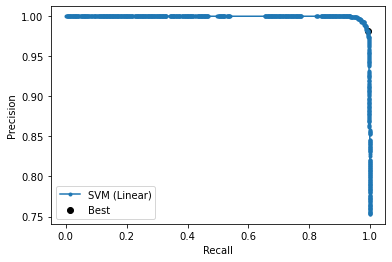

In [37]:
# plot the Precision-Recall curve for the optimized model
plt.plot(recall, precision, marker='.', label='SVM (Linear)')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [38]:
y_pred = clf_optimal.decision_function(df_test.Clean)
y_pred = to_labels(y_pred, thresholds[ix])
print(classification_report(df_test['LABEL'], y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       191
           1       0.92      0.91      0.91       201

    accuracy                           0.91       392
   macro avg       0.91      0.91      0.91       392
weighted avg       0.91      0.91      0.91       392



And we got our final results! 

With very simple ML and feature extraction approaches we were able to cross the $90\%$ across all classification metrics. 

We most also note that the vocabulary was reduced a lot during the processing phase and it was also reduced during model training were feature selection was done by considering only features that are not so frequent in the comments during vocabulary development.

Given the accuracy score, we can visualize the comment with wrong predictions manualy.

In [39]:
df_test['Prediction'] = y_pred
error = df_test[df_test['LABEL'] != df_test['Prediction']]
error[['Artist', 'COMMENT', 'Clean', 'LABEL', 'Prediction']]

,Artist,COMMENT,Clean,LABEL,Prediction
283,Psy,Lol this youtuber (officialpsy) is getting so ...,lol youtub officialpsi get much money lol,0,1
273,Psy,Come and watch my video it is called the odowd...,come watch video call odowd crowd zombi movi p...,1,0
646,KatyPerry,"This song is the most boring, asinine song I h...",song bore asinin song ever url guy like teenag...,0,1
472,KatyPerry,Watch my videos xx?,watch video xx,1,0
1146,Eminem,Aslamu Lykum... From Pakistan?,aslamu lykum emoticon pakistan,1,0
861,LMFAO,like if ur watchin in 900000000000000000000000...,like ur watchin number number,1,0
1683,Shakira,Yea stil the best WK song ever<br />Thumbs up ...,yea stil best wk song ever,1,0
46,Psy,"now its 1,884,034,783 views! pls. comment the ...",number view url view count next hour emoticon,0,1
28,Psy,I dont even watch it anymore i just come here ...,even watch anymor come check number billion,0,1
822,LMFAO,HOW DO YOU PUT A PICTURE FOR YOUR IMAGE THINGI...,put pictur imag thingi,1,0


We see some obvious comments that the model was not able to correctly predict which leaves room for further improvement:

- Another way to deal with textual could be by considering LDA to reduce the dimensionality of the vectors (Basically a PCA for NLP). 
- More processing steps can be considered such as:
    - Slang, swear, and obscene words normalization;
    - Word segmentation to separate joined words;
    - Word correction.
- Perform lemmatization instead of stemming or before it.